# Implementation


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/memento')

In [4]:
import scanpy as sc
import scipy.stats as stats
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import string
import random
import logging
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pymare import core, estimators


In [5]:
import memento

In [6]:
import memento.model.rna as rna
import memento.estimator.hypergeometric as hg

In [7]:
data_path = '/data_volume/memento/'

In [8]:
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

### Pseudobulk vs WLS vs LMM

In [9]:
num_ind = 10
num_cell_per_ind = 100
beta_geno = 1
beta_age = 1
ind_intercepts = stats.norm.rvs(scale=2, size=num_ind)
ind_variances = np.exp(stats.norm.rvs(scale=1, size=num_ind))
intercept = 10
geno = np.array([0 for i in range(int(num_ind/2))] + [1 for i in range(int(num_ind/2))])
age = stats.norm.rvs(scale=10, loc=30, size=num_ind)

In [41]:
num_trial = 50
num_effect_size = 20

lm_power = np.zeros(num_effect_size)
lmm_power = np.zeros(num_effect_size)
pseudobulk_power = np.zeros(num_effect_size)
wls_power = np.zeros(num_effect_size)
effect_sizes = np.linspace(0, 4, num_effect_size)

for jdx, effect_size in enumerate(effect_sizes):#enumerate(np.linspace(0.1, 2, num_effect_size)):
    
    print(jdx)
    lm_pv = np.zeros(num_trial)
    lmm_pv = np.zeros(num_trial)
    pseudob_pv = np.zeros(num_trial)
    wls_pv = np.zeros(num_trial)

    for idx in range(num_trial):

        data = []
        for ind in range(num_ind):
            mu = intercept+effect_size*geno[ind]+beta_age*age[ind]+ind_intercepts[ind]
            data.append(stats.norm.rvs(loc=mu, scale=np.sqrt(ind_variances[ind]), size=num_cell_per_ind))

        df = pd.DataFrame()
        df['expr'] = np.concatenate(data)
        df['geno'] = np.repeat(geno, num_cell_per_ind)
        df['age'] = np.repeat(age, num_cell_per_ind)
        df['ind'] = ['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)]
        dummy_df = pd.get_dummies(df, drop_first=True)

        pseudobulks = df.groupby('ind').agg({'expr':['mean', 'var'], 'geno':'mean', 'age':'mean'})
        pseudobulks.columns = ['expr', 'var', 'geno', 'age']

        lm_pv[idx] = smf.ols("expr ~ geno + age", df).fit().pvalues['geno']
        lmm_pv[idx] = smf.mixedlm("expr ~ geno + age", df, groups=df["ind"]).fit().pvalues['geno']
        pb_model = smf.ols("expr ~ geno + age", pseudobulks).fit()
        pseudob_pv[idx] = pb_model.pvalues['geno']
        
        pseudobulks['var'] = pseudobulks['var']/num_cell_per_ind
        
        dsl = estimators.DerSimonianLaird()
        dsl.fit(
            y=pseudobulks[['expr']].values,
            X=sm.add_constant(pseudobulks[['age', 'geno']]).values,
            v=pseudobulks[['var']].values)
        wls_pv[idx] =float(dsl.summary().get_fe_stats()['p'][-1])
        
        
    lm_power[jdx] = (lm_pv < 0.05).mean()
    lmm_power[jdx] = (lmm_pv < 0.05).mean()
    pseudobulk_power[jdx] = (pseudob_pv < 0.05).mean()
    wls_power[jdx] = (wls_pv < 0.05).mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


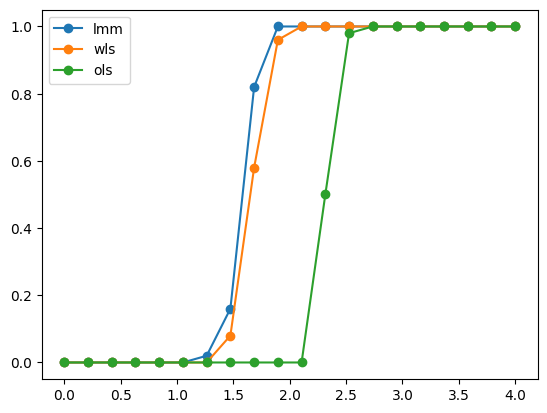

In [43]:
plt.plot(effect_sizes, lmm_power, '-o', label='lmm')
plt.plot(effect_sizes, wls_power, '-o', label='wls')
plt.plot(effect_sizes, pseudobulk_power, '-o', label='ols')
plt.legend()

In [44]:
dsl.summary().get_fe_stats()

[autoreload of memento.util failed: Traceback (most recent call last):
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ssm-user/Github/memento/memento/util.py", line 113
    
    ^
Ind

{'est': array([[3.81191848],
        [1.18296308],
        [5.80263413]]),
 'se': array([[4.55873337],
        [0.13360197],
        [1.85588174]]),
 'ci_l': array([[-5.12303474],
        [ 0.92110804],
        [ 2.16517276]]),
 'ci_u': array([[12.74687171],
        [ 1.44481813],
        [ 9.4400955 ]]),
 'z': array([[0.8361793 ],
        [8.85438365],
        [3.12661847]]),
 'p': array([[0.40305404],
        [0.        ],
        [0.00176829]])}

Bad pipe message: %s [b'\xaa\xd7\xfc\x8e\xea\x9a\\\xa7S\x7f\xbc\x0f\x8b.\xb9{m\xed \xf2\xe6\xb2\x8eq\xdfB4\xfc\xc3\xc92R\xe75t]\xa6V!\x10\x97\x15B\xcf:8:\xef\x17\xce\x01\x00&\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\t\xc0\x13\xc0\n\xc0\x14\x00\x9c\x00\x9d\x00/\x005\xc0\x12\x00\n\x13\x01']
Bad pipe message: %s [b'\x13\x03\x01\x00\x00\x89\x00\x00\x00\x0e\x00\x0c\x00\x00\tloc']
Bad pipe message: %s [b'host\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\n\x00\n\x00\x08\x00\x1d\x00\x17\x00\x18\x00\x19\x00\x0b\x00\x02\x01\x00\x00\r\x00\x1a\x00\x18\x08\x04\x04\x03\x08\x07\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x05\x03\x06\x03\x02\x01\x02\x03\xff\x01\x00\x01\x00\x00\x12\x00\x00\x00+\x00\x05\x04\x03\x04\x03\x03\x003\x00&\x00$\x00\x1d\x00 wg\x11\xa8E']


In [56]:
pseudobulks

,expr,geno,age
ind,,,
donor_0,46.831113,0.0,38.808083
donor_1,33.255335,0.0,20.637847
donor_10,57.820048,1.0,43.362017
donor_11,34.107427,1.0,17.284894
donor_12,45.045919,1.0,34.394089
donor_13,39.041103,1.0,32.189609
donor_14,29.987195,1.0,19.958391
donor_15,37.665257,1.0,23.605144
donor_16,53.365008,1.0,42.333040


In [50]:
%%time

# actually bootstrap everything

lmm_result = []
boot_result = []

for univ in range(1):
    
    # Parameter generation
    num_ind = 20
    num_cell_per_ind = 1000
    beta_geno = 1
    beta_age = 1
    ind_intercepts = stats.norm.rvs(scale=2, size=num_ind)
    intercept = 10
    geno = np.array([0 for i in range(int(num_ind/2))] + [1 for i in range(int(num_ind/2))])
    age = stats.norm.rvs(scale=10, loc=30, size=num_ind)
    
    # Data generation
    data = []
    for ind in range(num_ind):
        mu = intercept+beta_geno*geno[ind]+beta_age*age[ind]+ind_intercepts[ind]
        data.append(stats.norm.rvs(loc=mu, scale=1, size=num_cell_per_ind))

    df = pd.DataFrame()
    df['expr'] = np.concatenate(data)
    df['geno'] = np.repeat(geno, num_cell_per_ind)
    df['age'] = np.repeat(age, num_cell_per_ind)
    df['ind'] = ['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)]
    dummy_df = pd.get_dummies(df, drop_first=True)

    #LMM
    lmm_result.append(smf.mixedlm("expr ~ geno + age", df, groups=df["ind"]).fit())
    
    # bootstrap
    num_boot = 100
    b_coefs = np.zeros(num_boot)
    for b in range(num_boot):
        b_donors = np.random.choice(num_ind, size=num_ind)
        genos = []
        exprs = []
        ages = []
        for d in b_donors:
            genos.append(np.ones(num_cell_per_ind)*int(d >= num_ind/2))
            b_idxs = np.random.choice(num_cell_per_ind, size=num_cell_per_ind)
            exprs.append(df.query('ind.str.contains("{}")'.format(d), engine='python').expr.values[b_idxs])
            ages.append(np.ones(num_cell_per_ind)*age[d])

        genos = np.concatenate(genos)
        exprs = np.concatenate(exprs)
        ages = np.concatenate(ages)
        b_coefs[b] = LinearRegression().fit(np.vstack([genos, ages]).T, exprs).coef_[0]
    boot_result.append(b_coefs)

CPU times: user 12.7 s, sys: 1.12 s, total: 13.9 s
Wall time: 12.6 s


In [51]:
pseudobulks = df.groupby(['ind', 'geno', 'age']).agg({'expr':['mean', 'var']}).reset_index()
pseudobulks.columns = ['ind', 'geno', 'age', 'mean', 'var']


In [52]:
smf.mixedlm("expr ~ geno + age", df, groups=df["ind"]).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: expr       
No. Observations: 20000   Method:             REML       
No. Groups:       20      Scale:              0.9938     
Min. group size:  1000    Log-Likelihood:     -28404.1178
Max. group size:  1000    Converged:          Yes        
Mean group size:  1000.0                                 
----------------------------------------------------------
            Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept   9.604     1.738   5.527  0.000   6.198  13.010
geno        0.950     1.374   0.692  0.489  -1.742   3.642
age         0.986     0.065  15.292  0.000   0.860   1.113
Group Var   7.423     2.487                               
=========================================================

"""

In [53]:
smf.ols('mean~geno+age', pseudobulks).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     150.8
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           1.52e-11
Time:                        00:07:16   Log-Likelihood:                -47.078
No. Observations:                  20   AIC:                             100.2
Df Residuals:                      17   BIC:                             103.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6039      1.762      5.451      0.000       5.887      13.321
geno           0.9503      1.393      0.682      0.504      -1.988       3.889
age            0.9864      0.065     15.081      0.000       0.848       1.124
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.385
Skew:                          -0.178   Prob(JB):                        0.825
Kurtosis:                       2.421   Cond. No.                         86.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
smf.wls('mean~geno+age', pseudobulks, weights=1/pseudobulks['var']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.956
Model:                            WLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     185.8
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           2.80e-12
Time:                        00:06:02   Log-Likelihood:                -43.876
No. Observations:                  20   AIC:                             93.75
Df Residuals:                      17   BIC:                             96.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8316      1.973      5.996      0.000       7.668      15.995
geno          -0.8917      1.067     -0.836      0.415      -3.142       1.359
age            0.9826      0.052     18.865      0.000       0.873       1.093
==============================================================================
Omnibus:                        0.730   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.758
Skew:                          -0.308   Prob(JB):                        0.685
Kurtosis:                       2.272   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
np.mean(boot_result[0])

1.0120044603239813

In [16]:
np.std(boot_result[0])

0.6294694268678616

In [17]:
lmm_result[0].bse['geno']

0.5967784298460402

### Perturbseq

In [9]:
adata = sc.read(data_path + 'tfko140/tfko.sng.guides.full.ct.details.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


In [1]:
guide_pairs = pd.read_csv('guide_pairs_to_test.csv')

NameError: name 'pd' is not defined

In [11]:
rna.MementoRNA.setup_anndata(
    adata=adata,
    q_column='q',
    label_columns=['donor', 'guide'])

2023-06-29 15:08:54 2997726 INFO     setup_anndata: creating groups
2023-06-29 15:09:18 2997726 INFO     setup_anndata: computing cell sizes


In [13]:
# Define expressed genes
adata.var['expr_genes'] = (adata.X.mean(axis=0).A1 > 0.1)
adata = adata[:, adata.var['expr_genes']]

2023-06-29 15:09:29 2997726 WARNING  /tmp/ipykernel_2997726/1251293065.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['expr_genes'] = (adata.X.mean(axis=0).A1 > 0.1)



In [16]:
model = rna.MementoRNA(adata=adata)

In [19]:
model.compute_estimate(
    estimator=[
        'mean', 
        'sem', 
        'var', 
        'total_umi',
        'cell_count'])

2023-06-29 15:10:27 2997726 INFO     compute_estimate: gene_list is None, using all genes...


In [33]:
for idx, row in guide_pairs.iterrows():
    
    sets = [(row['target1_guide1'], row['target2_guide1']), (row['target1_guide2'], row['target2_guide2'])]
    for t1, t2 in sets:
        

        groups = [f'memento_group^{d}^{g}' for d,g in itertools.product(donors, [t1,t2])]
        treatment = pd.DataFrame(index=groups)
        covariate = pd.DataFrame(index=groups)
        treatment['is_target1'] = treatment.index.str.contains(t1).astype(float)
        covariate['donor'] = covariate.index.str.split('^').str[1]
        covariate = pd.get_dummies(covariate, drop_first=True).astype(float)
        covariate = sm.add_constant(covariate)
        
        result = model.differential_mean(covariates=covariate, treatments=treatment, family='NB')
        break
    break

NameError: name 'model' is not defined

In [ ]:
alpha

63363.200169352494

In [ ]:
len(groups)

18

In [ ]:
model.differential_mean(

### Read some data

In [8]:
adata = sc.read(data_path + 'hbec/HBEC_type_I_filtered_counts_deep.h5ad')
adata.obs['q'] = 0.07

In [10]:
rna.MementoRNA.setup_anndata(
    adata=adata,
    q_column='q',
    label_columns=['donor', 'stim'])

2023-06-28 21:35:02 540777  INFO     setup_anndata: creating groups
2023-06-28 21:35:02 540777  INFO     setup_anndata: computing cell sizes


In [11]:
# Define expressed genes
adata.var['expr_genes'] = (adata.X.mean(axis=0).A1 > 0.02)
adata = adata[:, adata.var['expr_genes']]

In [51]:
model = rna.MementoRNA(adata=adata)

In [52]:
model.compute_estimate(
    estimator=[
        'mean', 
        'sem', 
        'var', 
        'total_umi',
        'cell_count']
)

2023-06-28 22:04:57 540777  INFO     compute_estimate: gene_list is None, using all genes...


In [96]:
expr = model.estimates['mean']*model.estimates['total_umi'].values
expr_se = model.estimates['sem']*model.estimates['cell_count'].values**2

# Transform standard error to weights
weights = np.sqrt(1/expr_se).replace([-np.inf, np.inf], np.nan)
mean_weight = np.nanmean(weights)
weights /= mean_weight
weights = weights.fillna(1.0)


In [102]:
design_matrix = pd.DataFrame(
    stats.bernoulli.rvs(size=len(adata.uns['memento']['groups']), p=0.5),
    index=adata.uns['memento']['groups'],
    columns=['treatment'])
design_matrix['intercept'] = 1

In [141]:
def fit_nb(endog, exog, offset, weights=None):
    
    poi = sm.GLM(
        endog,
        exog, 
        offset=offset,
        var_weights=weights,
        family=sm.families.Poisson()).fit()

    mu = poi.predict()
    resid = poi.resid_response
    df_resid=poi.df_resid

    alpha = ((resid**2 / mu - 1) / mu).sum() / df_resid
    
    nb = sm.GLM(
        endog,
        exog, 
        offset=offset,
        var_weights=weights,
        family=sm.families.NegativeBinomial(alpha=alpha))\
        .fit(start_params=poi.params)
    
    return nb

In [142]:
fit_nb(
    expr.iloc[:, [idx]],
    design_matrix, 
    np.log(model.estimates['total_umi']['total_umi'].values),
    weights.iloc[:, idx]).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              LINC01409   No. Observations:                   10
Model:                            GLM   Df Residuals:                        8
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66.919
Date:                Wed, 28 Jun 2023   Deviance:                       9.4006
Time:                        22:31:43   Pearson chi2:                     9.37
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2345
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.1371      0.083      1.646      0.100      -0.026       0.300
intercept    -11.7864      0.053   -222.744      0.000     -11.890     -11.683
==============================================================================
"""

In [143]:
%%time



poi = sm.GLM(
    expr.iloc[:, [idx]],
    design_matrix, 
    offset=np.log(model.estimates['total_umi']['total_umi'].values),
    var_weights=weights.iloc[:, idx],
    family=sm.families.Poisson()).fit()

mu = poi.predict()
resid = poi.resid_response
df_resid=poi.df_resid

alpha = ((resid**2 / mu - 1) / mu).sum() / df_resid
nb = sm.GLM(
    expr.iloc[:, [idx]],
    design_matrix, 
    offset=np.log(model.estimates['total_umi']['total_umi'].values),
    var_weights=weights.iloc[:, idx],
    family=sm.families.NegativeBinomial(alpha=alpha))\
    .fit(start_params=poi.params)

CPU times: user 3.31 ms, sys: 3.77 ms, total: 7.08 ms
Wall time: 6.63 ms


In [113]:
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              LINC01409   No. Observations:                   10
Model:                            GLM   Df Residuals:                        8
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.940
Date:                Wed, 28 Jun 2023   Deviance:                      0.20952
Time:                        22:20:05   Pearson chi2:                    0.204
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008176
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.1621      0.567      0.286      0.775      -0.950       1.274
intercept    -11.7785      0.370    -31.869      0.000     -12.503     -11.054
==============================================================================
"""

In [110]:
design_matrix

,treatment,intercept
memento_group^d2513^lambda,1,1
memento_group^d2513^alpha,0,1
memento_group^d2614^alpha,0,1
memento_group^d2614^gamma,0,1
memento_group^d2513^beta,1,1
memento_group^d2513^gamma,0,1
memento_group^d2614^lambda,0,1
memento_group^d2614^beta,1,1
memento_group^d2513^control,1,1
memento_group^d2614^control,0,1


In [48]:
expr

,LINC01409,LINC01128,FAM41C,NOC2L,KLHL17,PLEKHN1,AL645608.7,HES4,ISG15,AGRN,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL354822.1,AL592183.1,AC240274.1,AC007325.4,AC007325.2
memento_group^d2513^lambda,616.464050,415.312622,299.225250,2116.593262,227.171005,905.681763,386.290771,26673.078125,1.372773e+05,2995.254639,...,18393.845703,372033.031250,106805.398438,16415.357422,525649.687500,238.179291,484.364594,266.200378,438.329956,202.152161
memento_group^d2513^alpha,562.351196,349.009827,188.486038,2024.671387,214.376968,1638.378662,534.388977,58378.890625,7.846166e+05,4438.742676,...,19013.269531,350050.687500,110214.617188,19982.626953,457985.843750,221.626434,595.491577,256.838135,466.036926,213.341339
memento_group^d2614^alpha,749.359253,414.262268,233.158081,2785.968018,232.073624,2112.520752,488.005280,98711.546875,1.129824e+06,5374.565430,...,30381.041016,618881.812500,181654.015625,24307.001953,647822.687500,254.847214,136.641495,228.820267,348.110443,217.975693
memento_group^d2614^gamma,621.043030,364.456940,220.978195,2160.559326,186.417633,1035.769897,316.281586,30780.902344,8.706751e+04,2537.583740,...,26350.865234,625070.875000,175277.609375,15735.532227,732543.812500,205.268860,154.998932,167.566406,237.734848,116.249199
memento_group^d2513^beta,626.418396,349.388489,239.816940,2135.611328,196.401810,1567.079834,629.519531,70510.320312,9.666938e+05,4759.125977,...,20355.498047,369992.062500,117563.015625,22912.857422,481184.468750,253.254959,696.709595,293.569031,574.733765,225.345245
memento_group^d2513^gamma,720.975708,463.049194,352.364197,2634.100098,264.019287,1160.669312,553.425049,31323.855469,9.142176e+04,3099.180176,...,23756.658203,506021.375000,142226.171875,21315.496094,735781.125000,268.081116,682.388306,315.807678,489.451111,222.385483
memento_group^d2614^lambda,650.988586,420.364655,284.086823,2428.889893,234.817169,984.345154,366.901794,34616.664062,1.259029e+05,2989.725586,...,26438.945312,621180.500000,171310.656250,16048.285156,745846.312500,205.465012,162.485077,189.740646,257.879547,158.291931
memento_group^d2614^beta,802.833252,406.427368,246.083405,2566.616455,236.061920,1772.691284,411.994843,97571.515625,1.111560e+06,5648.783203,...,29136.943359,607100.000000,178645.421875,22870.167969,640889.187500,234.948425,199.316422,216.018936,390.838348,163.684433
memento_group^d2513^control,111.890884,60.421078,89.512711,275.251587,36.923992,90.631615,15.664724,3476.449707,6.023086e+03,441.969025,...,2944.968018,55547.113281,22798.886719,2116.975586,84901.687500,32.448357,98.463982,51.469807,101.820709,30.210539
memento_group^d2614^control,153.860382,103.988388,77.460739,541.164062,67.910782,215.404526,115.660561,6349.658691,5.493346e+03,499.780945,...,5889.138184,143710.890625,40041.898438,3122.834961,180344.515625,44.566456,33.955391,46.688667,63.666363,33.955391


In [47]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              LINC01409   No. Observations:                   10
Model:                            GLM   Df Residuals:                        8
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                 0.0000
Date:                Wed, 28 Jun 2023   Deviance:                       0.0000
Time:                        22:03:51   Pearson chi2:                     0.00
No. Iterations:                     1   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment           0          0        nan        nan           0           0
intercept           0          0        nan        nan           0           0
==============================================================================
"""

In [8]:
import statsmodels.api as sm

In [9]:
import statsmodels.discrete.discrete_model as discrete

In [85]:
X = np.array([0, 0, 0, 0,0, 0, 1, 1, 1, 1, 1,1]).reshape(-1,1)
X = sm.add_constant(X)
beta = np.array([1, 2]).reshape(-1, 1)
Y = stats.poisson.rvs(np.exp(X@beta))

In [86]:
%%time
discrete.NegativeBinomial(endog=Y, exog=X).fit().summary()

Optimization terminated successfully.
         Current function value: 2.542510
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
CPU times: user 20 ms, sys: 7.92 ms, total: 27.9 ms
Wall time: 15.1 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               NegativeBinomial   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Wed, 28 Jun 2023   Pseudo R-squ.:                  0.2902
Time:                        17:30:44   Log-Likelihood:                -30.510
converged:                       True   LL-Null:                       -42.985
Covariance Type:            nonrobust   LLR p-value:                 5.882e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1527      0.229      5.024      0.000       0.703       1.602
x1             1.9534      0.245      7.968      0.000       1.473       2.434
alpha       1.392e-05      0.031      0.000      1.000      -0.061       0.061
==============================================================================
"""

In [83]:
%%time
weights = stats.norm.rvs(loc=10, scale=2,size=12)
weights /= weights.mean()
weighted_model = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson(), var_weights=weights).fit()
weighted_model.summary()

CPU times: user 4.34 ms, sys: 0 ns, total: 4.34 ms
Wall time: 3.94 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.868
Date:                Wed, 28 Jun 2023   Deviance:                       7.2673
Time:                        17:26:39   Pearson chi2:                     6.99
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9995
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0173      0.252      4.032      0.000       0.523       1.512
x1             2.0166      0.267      7.554      0.000       1.493       2.540
==============================================================================
"""

In [84]:
%%time
weights = stats.norm.rvs(loc=10, scale=2,size=12)
weights /= weights.mean()
weighted_model = sm.GLM(endog=Y, exog=X, family=sm.families.NegativeBinomial(), var_weights=weights).fit()
weighted_model.summary()

CPU times: user 485 µs, sys: 4.4 ms, total: 4.89 ms
Wall time: 4.45 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.263
Date:                Wed, 28 Jun 2023   Deviance:                       1.6960
Time:                        17:26:40   Pearson chi2:                     1.63
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5707
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8993      0.476      1.888      0.059      -0.034       1.833
x1             2.1066      0.639      3.299      0.001       0.855       3.358
==============================================================================
"""

In [72]:
sm.GLM(endog=Y, exog=X, family=sm.families.NegativeBinomial()).loglike(weighted_model.params)

-37.159871451123635

In [69]:
weighted_model.loglike

### Generate multi-index Pandas DataFrame

In [ ]:
adata

AnnData object with n_obs × n_vars = 69958 × 36601
    obs: 'NUM.SNPS', 'BEST.GUESS', 'DROPLET.TYPE', 'batch', 'HTO_classification', 'condition', 'donor', 'stim', 'time', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Toy HBEC dataset

In [65]:
adata = sc.read(data_path + 'hbec/HBEC_type_I_filtered_counts_deep.h5ad')

In [66]:
mean_filter = adata.X.mean(axis=0).A1>0.5
mt_filter  =~adata.var.index.str.contains('MT-')
gene_filter = mean_filter & mt_filter

In [67]:
adata = adata[
    (adata.obs['donor'] == 'd2513') &\
    adata.obs['stim'].isin(['control', 'beta']) & \
    adata.obs['cell_type'].isin(['ciliated']), gene_filter]

In [69]:
adata.write('toy_hbec.h5ad')